<a href="https://colab.research.google.com/github/jjayli/my-data-science/blob/main/puppy_care_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import re
import numpy as np
import platform
import matplotlib.font_manager as fm

In [22]:
# 1.데이터 로드
df = pd.read_csv('care_timeline.csv')

In [23]:
# 2.소변 카운트
def parse_urine(text):
    if not isinstance(text, str): return 0
    text = text.replace(" ", "")
    count = 0
    if '소변' in text:
        match = re.search(r'소변([0-9.]+)', text)
        if match:
            try: count += float(match.group(1))
            except: count += 1
        elif '소변2회' in text: count += 2
        else: count += 1
    return count

In [24]:
df['urine_count'] = df['내용'].apply(parse_urine)
df['full_datetime'] = pd.to_datetime(df['날짜'] + ' ' + df['시간'], errors='coerce')
df = df.dropna(subset=['full_datetime']).sort_values('full_datetime')

In [25]:
# 3.결측치 보완
target_interval_min = 51
synthetic_rows = []

# 첫 번째 결측
jan1_start = pd.Timestamp('2026-01-01 00:00:00')
first_event_jan1 = df[df['full_datetime'].dt.date == pd.Timestamp('2026-01-01').date()].iloc[0]['full_datetime']

current_time = jan1_start
while current_time < first_event_jan1 - pd.Timedelta(minutes=target_interval_min):
    synthetic_rows.append({'full_datetime': current_time, 'urine_count': 1})
    current_time += pd.Timedelta(minutes=target_interval_min)

# 두 번째 결측
gap2_start = pd.Timestamp('2026-01-01 05:30:00')
gap2_end = pd.Timestamp('2026-01-01 12:40:00')

curr = gap2_start + pd.Timedelta(minutes=target_interval_min)
while curr < gap2_end - pd.Timedelta(minutes=10):
    synthetic_rows.append({'full_datetime': curr, 'urine_count': 1})
    curr += pd.Timedelta(minutes=target_interval_min)


In [15]:
# 4.데이터 병합
synthetic_df = pd.DataFrame(synthetic_rows)
original_urine = df[df['urine_count'] > 0][['full_datetime', 'urine_count']]
combined_df = pd.concat([original_urine, synthetic_df]).sort_values('full_datetime')

In [16]:
# 5.주기 계산
combined_df['interval_min'] = combined_df['full_datetime'].diff().dt.total_seconds() / 60
combined_df = combined_df.dropna(subset=['interval_min'])

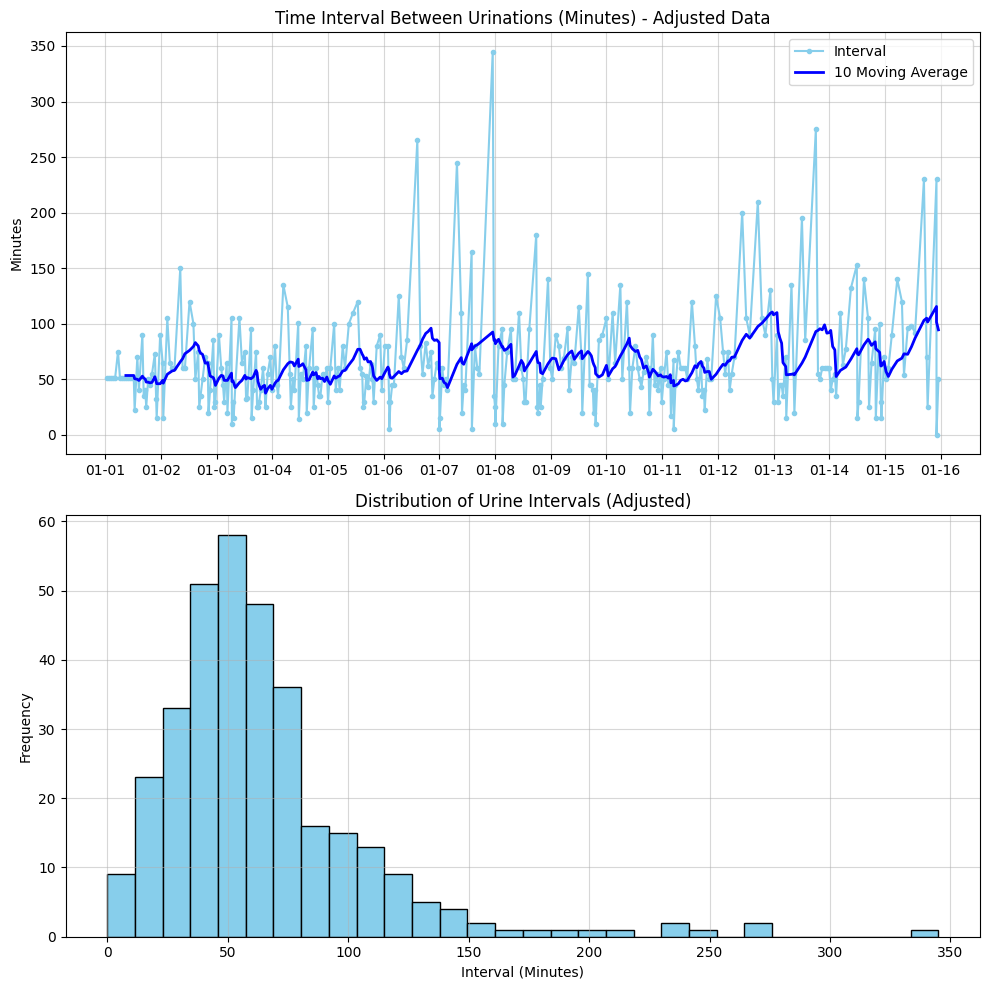

In [20]:
# 6. 시각화 2개 그래프
plt.style.use('default')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Sub1
ax1.plot(combined_df['full_datetime'], combined_df['interval_min'], marker='.', linestyle='-', color='skyblue', label='Interval')

# 이동평균 10시간
combined_df['rolling_avg'] = combined_df['interval_min'].rolling(window=10).mean()
ax1.plot(combined_df['full_datetime'], combined_df['rolling_avg'], color='blue', linewidth=2, label='10 Moving Average')

ax1.set_title('Time Interval Between Urinations (Minutes) - Adjusted Data')
ax1.set_ylabel('Minutes')
ax1.grid(True, alpha=0.5)
ax1.legend()

ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax1.xaxis.set_major_locator(mdates.DayLocator())

# Sub2
ax2.hist(combined_df['interval_min'], bins=30, color='skyblue', edgecolor='black')
ax2.set_title('Distribution of Urine Intervals (Adjusted)')
ax2.set_xlabel('Interval (Minutes)')
ax2.set_ylabel('Frequency')
ax2.grid(True, alpha=0.5)

plt.tight_layout()
plt.show() # or plt.savefig('filename.png')

In [26]:
# 데이터 전처리
df = df.dropna(subset=['날짜', '내용'])

def parse_counts(text):
    urine = 0
    stool = 0

    # 텍스트가 비어있지 않은 경우만 처리
    if isinstance(text, str):
        # 소변 카운트 (소변 2회 등의 경우 2로 처리)
        if '소변' in text:
            if '2회' in text:
                urine = 2
            else:
                urine = 1
        # 대변 카운트
        if '대변' in text:
            stool = 1
    return urine, stool

df[['소변', '대변']] = df['내용'].apply(lambda x: pd.Series(parse_counts(x)))

In [31]:
# 날짜별 합계 계산
daily_counts = df.groupby('날짜')[['소변', '대변']].sum()
daily_counts.index = pd.to_datetime(daily_counts.index)

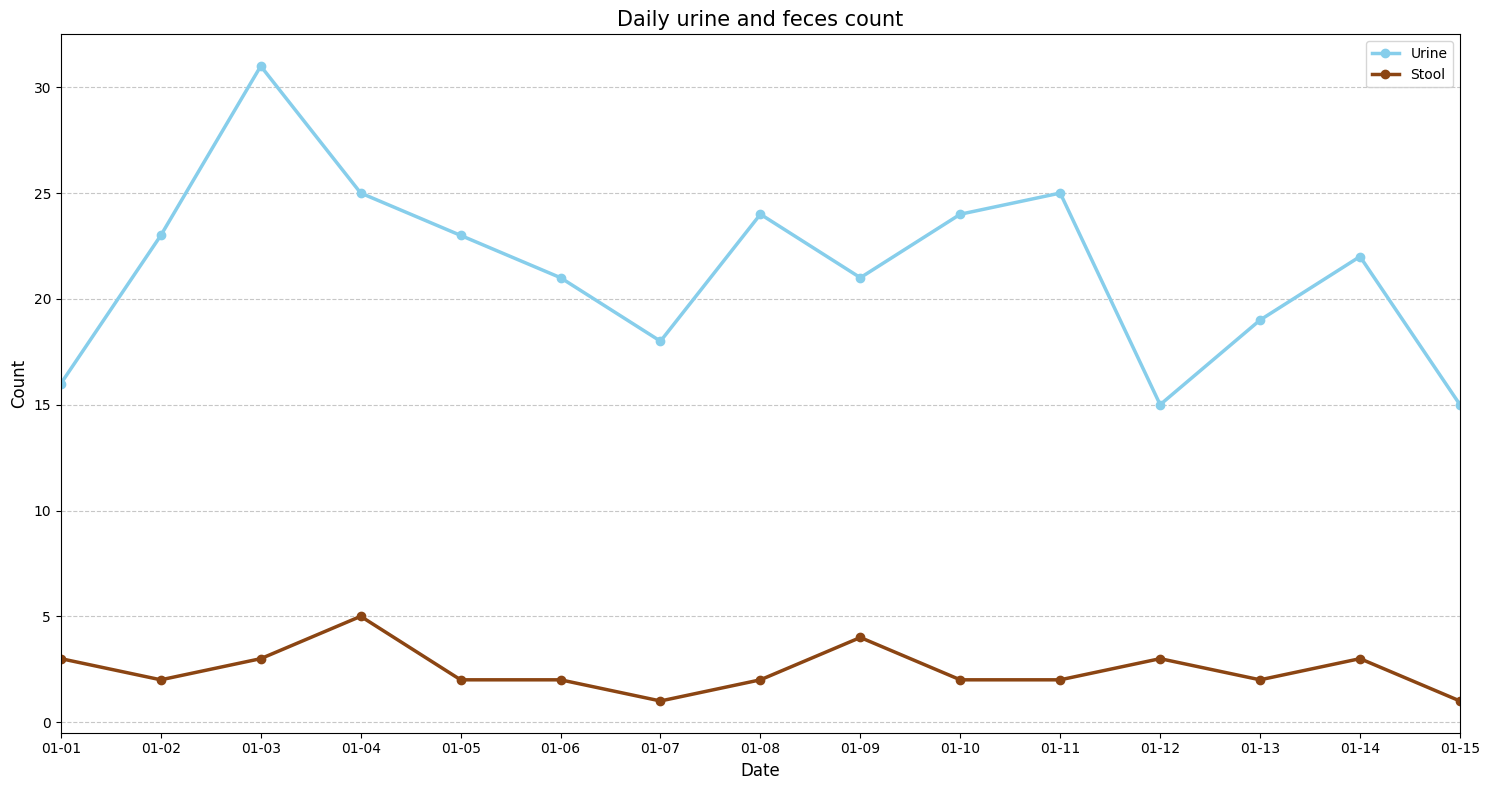

In [30]:
# 선그래프 그리기
plt.figure(figsize=(15, 8))
ax = daily_counts.plot(kind='line', marker='o', color=['skyblue', 'saddlebrown'], ax=plt.gca(), linewidth=2.5)

plt.title('Daily urine and feces count', fontsize=15)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Count', fontsize=12)

ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.xticks(rotation=0)

# 폰트 사이즈
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.7) # y축 격자선 추가
plt.legend(['Urine', 'Stool'])

plt.tight_layout()
plt.show()

In [29]:
# (선택사항) 텍스트로도 결과 출력
print("\n[일별 집계 결과]")
print(daily_counts)


[일별 집계 결과]
            소변  대변
날짜                
2026-01-01  16   3
2026-01-02  23   2
2026-01-03  31   3
2026-01-04  25   5
2026-01-05  23   2
2026-01-06  21   2
2026-01-07  18   1
2026-01-08  24   2
2026-01-09  21   4
2026-01-10  24   2
2026-01-11  25   2
2026-01-12  15   3
2026-01-13  19   2
2026-01-14  22   3
2026-01-15  15   1


점점 약에 적응하면서 대소변 횟수가 줄어드는 모습을 보이는 듯함. 더 많은 데이터 기록 후 재분석 필요.